In [1]:
import kagglehub

import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil
from pathlib import Path
import numpy as np

import random
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

AUTOTUNE = tf.data.AUTOTUNE
SEED = 42
IMG_SIZE = (224, 224)
BATCH_SIZE = 64
NUM_CLASSES = 4


/Users/mikolajkahl/.pyenv/versions/tfmacos-310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# machine optimizations
print(tf.config.list_physical_devices("GPU"))
mixed_precision.set_global_policy('mixed_float16') # uses less precise float16 instead of float32 for all layers apart from the last one. remember to change it in the last layer, otherwise the model will not be able to predict

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### 1. Load Dataset from Kaggle

In [3]:
# Download latest version of dataset from kaggle url(https://www.kaggle.com/datasets/derekkunowilliams/mushrooms)
path = kagglehub.dataset_download("derekkunowilliams/mushrooms")
source_root = Path(os.path.join(path, "mushroom_dataset"))
print("Path to dataset files:", source_root)

Path to dataset files: /Users/mikolajkahl/.cache/kagglehub/datasets/derekkunowilliams/mushrooms/versions/1/mushroom_dataset


In [4]:
# Root path of the dataset
root_dir = "mushroom_dataset_4class"

dest_root = Path(root_dir)
if not dest_root.exists():
    dest_root.mkdir(exist_ok=True)

    # Define the top-level labels
    labels = ["edible", "deadly", "poisonous", "conditionally_edible"]

    # Create destination folders and flatten species into category
    for label in labels:
        src_label_path = source_root / label
        dst_label_path = dest_root / label
        dst_label_path.mkdir(parents=True, exist_ok=True)

        for species_dir in src_label_path.iterdir():
            if species_dir.is_dir():
                for img_file in species_dir.glob("*.*"):  # Match .png, .jpg, etc.
                    # Generate a unique filename to avoid overwriting
                    dest_file = dst_label_path / f"{species_dir.name}_{img_file.name}"
                    shutil.copy(img_file, dest_file)

    print("Dataset flattened to 4-class format at:", dest_root.resolve())
else:
    print("Directory 'mushroom_dataset_4class' already exists. Skipping operation.")


Directory 'mushroom_dataset_4class' already exists. Skipping operation.


### 2. Basic Exploratory Data Analysis

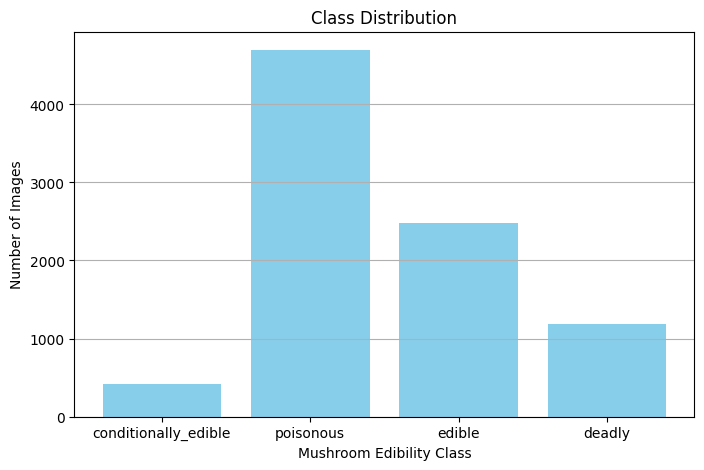

In [5]:
# Count number of images per class
class_counts = {}
for class_name in os.listdir(root_dir):
    class_path = os.path.join(root_dir, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len([
            f for f in os.listdir(class_path) 
            if os.path.isfile(os.path.join(class_path, f))
        ])

# Plot
plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), class_counts.values(), color="skyblue")
plt.title("Class Distribution")
plt.ylabel("Number of Images")
plt.xlabel("Mushroom Edibility Class")
plt.grid(True, axis='y')
plt.show()


In [6]:
df = pd.DataFrame(list(class_counts.items()), columns=["Class", "Count"])
print(df.sort_values("Count", ascending=False))

                  Class  Count
1             poisonous   4696
2                edible   2475
3                deadly   1190
0  conditionally_edible    420


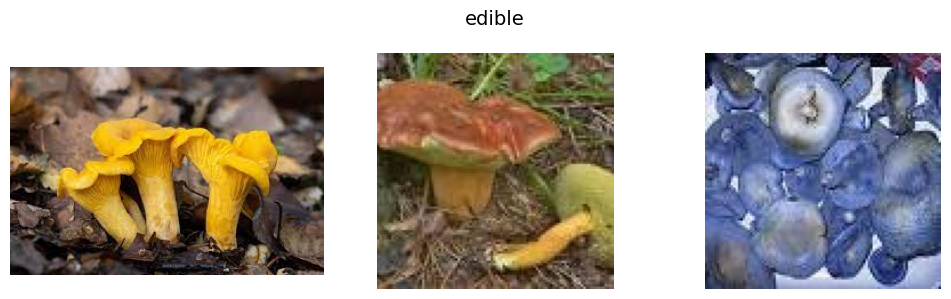

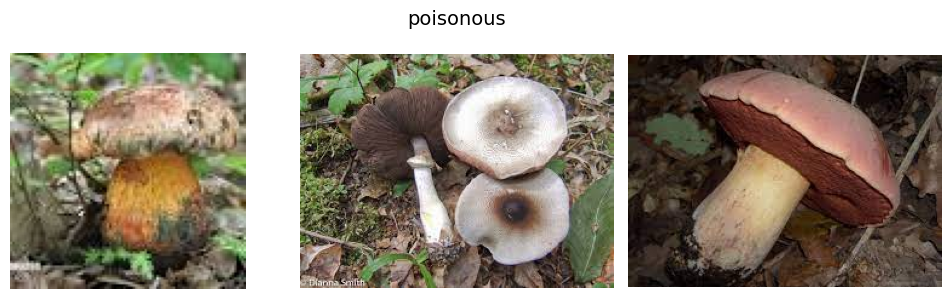

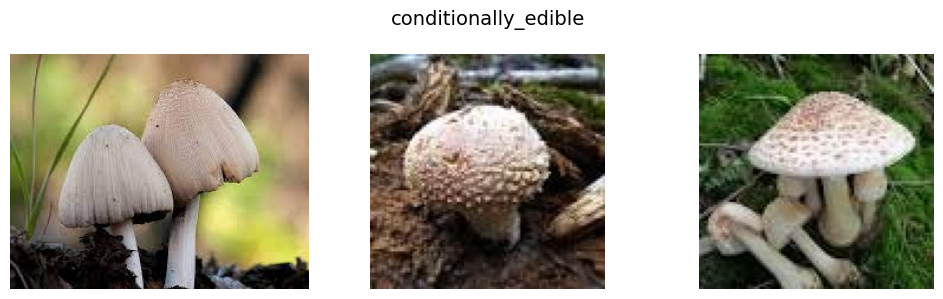

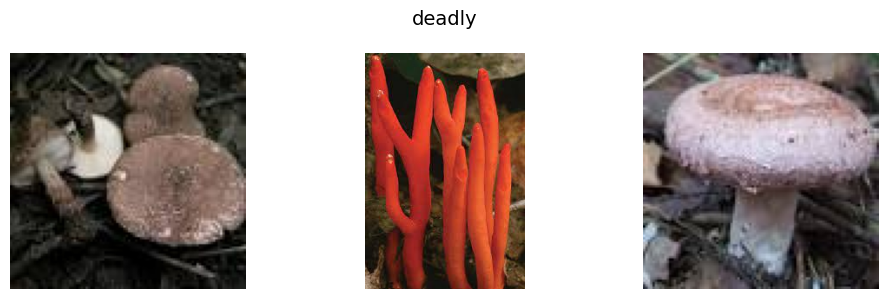

In [7]:
# Root directory with your 4 classes
data_dir = "mushroom_dataset_4class"
class_names = ["edible", "poisonous", "conditionally_edible", "deadly"]

def show_3_random_images_per_class():
    for class_name in class_names:
        class_path = os.path.join(root_dir, class_name)
        all_images = os.listdir(class_path)
        sample_imgs = random.sample(all_images, min(3, len(all_images)))

        plt.figure(figsize=(10, 3))
        for i, img_name in enumerate(sample_imgs):
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path)

            plt.subplot(1, 3, i + 1)
            plt.imshow(img)
            plt.axis('off')

        plt.suptitle(f"{class_name}", fontsize=14)
        plt.tight_layout()
        plt.show()

show_3_random_images_per_class()


### 3. Train-Test split

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 8781 files belonging to 4 classes.
Using 7025 files for training.


2025-04-10 18:32:21.127181: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-04-10 18:32:21.127207: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-04-10 18:32:21.127213: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
I0000 00:00:1744302741.127226 19521461 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1744302741.127248 19521461 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 8781 files belonging to 4 classes.
Using 1756 files for validation.


In [9]:
for images, labels in train_ds.take(1):
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")
    print(f"Image dtype: {images.dtype}")
    print(f"Label dtype: {labels.dtype}")


Image batch shape: (64, 224, 224, 3)
Label batch shape: (64,)
Image dtype: <dtype: 'float32'>
Label dtype: <dtype: 'int32'>


2025-04-10 18:32:21.478814: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-04-10 18:32:21.479725: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [10]:
def get_augmentation(name):
    if name == "flip":
        return tf.keras.Sequential([
            layers.RandomFlip("horizontal")
        ])
    elif name == "flip_zoom":
        return tf.keras.Sequential([
            layers.RandomFlip("horizontal"),
            layers.RandomZoom(0.1)
        ])
    elif name == "flip_rotate":
        return tf.keras.Sequential([
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.15)
        ])
    else:  # default / none
        return tf.keras.Sequential([])


### 4. Model Training Testing Framework

In [11]:
def get_classifier(name):
    if name == "simple":
        return [
            layers.GlobalAveragePooling2D(),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(NUM_CLASSES, activation='softmax', dtype='float32')
        ]
    elif name == "deep":
        return [
            layers.GlobalAveragePooling2D(),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.4),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(NUM_CLASSES, activation='softmax', dtype='float32')
        ]
    elif name == "minimal":
        return [
            layers.GlobalAveragePooling2D(),
            layers.Dense(NUM_CLASSES, activation='softmax', dtype='float32')
        ]
    else:
        raise ValueError("Unknown classifier head")


In [12]:
def build_model(fine_tune, fine_tune_at, augmentation_name, classifier_name):
    base_model = MobileNetV2(
        input_shape=(*IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )

    if fine_tune:
        base_model.trainable = True
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False
    else:
        base_model.trainable = False

    data_aug = get_augmentation(augmentation_name)
    classifier_head = get_classifier(classifier_name)

    model = models.Sequential([
        layers.InputLayer(input_shape=(*IMG_SIZE, 3)),
        data_aug,
        base_model,
        *classifier_head
    ])
    return model


In [13]:
def train_model(model, learning_rate=1e-5, epochs=10):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs
    )
    return model, history


In [14]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Train Acc')
    plt.plot(epochs, val_acc, label='Val Acc')
    plt.title("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.title("Loss")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [15]:
def plot_confusion_matrix(model):
    y_true = []
    y_pred = []

    for images, labels in val_ds:
        preds = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()


In [16]:
def run_experiment(name, fine_tune, fine_tune_at, learning_rate, epochs, augmentation_name, classifier_name):
    print(f"\nRunning: {name} ({'fine-tuned' if fine_tune else 'frozen'})")
    model = build_model(
        fine_tune=fine_tune,
        fine_tune_at=fine_tune_at,
        augmentation_name=augmentation_name,
        classifier_name=classifier_name
    )

    model, history = train_model(
        model,
        learning_rate=learning_rate,
        epochs=epochs
    )

    plot_history(history)
    plot_confusion_matrix(model)


    val_acc = history.history['val_accuracy'][-1]
    val_loss = history.history['val_loss'][-1]

    print(f"{name} done | Val Acc: {val_acc:.4f} | Val Loss: {val_loss:.4f}")

    return {
        "name": name,
        "fine_tune": fine_tune,
        "fine_tune_at": fine_tune_at,
        "learning_rate": learning_rate,
        "epochs": epochs,
        "augmentation": augmentation_name,
        "classifier": classifier_name,
        "val_accuracy": val_acc,
        "val_loss": val_loss,
        "history": history
    }


### 5. Training Experiments

In [17]:
experiments = [
    # Baseline (frozen)
    {
        "name": "ft_last_0_flip_simple",
        "fine_tune": False,
        "fine_tune_at": None,
        "learning_rate": 1e-3,
        "epochs": 10,
        "augmentation_name": "flip",
        "classifier_name": "simple"
    },

    # fine-tuning influence experiment
    {
        "name": "ft_last_30_flip_simple",
        "fine_tune": True,
        "fine_tune_at": -30,
        "learning_rate": 1e-5,
        "epochs": 10,
        "augmentation_name": "flip",
        "classifier_name": "simple"
    },

    {
        "name": "ft_last_50_flip_simple",
        "fine_tune": True,
        "fine_tune_at": -50,
        "learning_rate": 1e-5,
        "epochs": 10,
        "augmentation_name": "flip",
        "classifier_name": "simple"
    },

    {
        "name": "ft_last_80_flip_simple",
        "fine_tune": True,
        "fine_tune_at": -80,
        "learning_rate": 1e-5,
        "epochs": 10,
        "augmentation_name": "flip",
        "classifier_name": "simple"
    },


    {
        "name": "ft_all_layers_flip_simple",
        "fine_tune": True,
        "fine_tune_at": 0,
        "learning_rate": 1e-5,
        "epochs": 10,
        "augmentation_name": "flip",
        "classifier_name": "simple"
    },

    # testing different augmentations

    {
        "name": "ft_last_30_flip_zoom_simple",
        "fine_tune": True,
        "fine_tune_at": -30,
        "learning_rate": 1e-5,
        "epochs": 10,
        "augmentation_name": "flip_zoom",
        "classifier_name": "simple"
    },

        {
        "name": "ft_last_30_flip_rotate_simple",
        "fine_tune": True,
        "fine_tune_at": -30,
        "learning_rate": 1e-5,
        "epochs": 10,
        "augmentation_name": "flip_rotate",
        "classifier_name": "simple"
    },

    # testing different classifiers

    {
        "name": "ft_last_30_flip_deep",
        "fine_tune": True,
        "fine_tune_at": -30,
        "learning_rate": 1e-5,
        "epochs": 10,
        "augmentation_name": "flip",
        "classifier_name": "deep"
    },

    {
        "name": "ft_last_30_flip_minimal",
        "fine_tune": True,
        "fine_tune_at": -30,
        "learning_rate": 1e-5,
        "epochs": 10,
        "augmentation_name": "flip",
        "classifier_name": "minimal"
    },

    # testing different learning rates

    {
        "name": "ft_last_30_flip_simple_lr_1e-4",
        "fine_tune": True,
        "fine_tune_at": -30,
        "learning_rate": 1e-4,
        "epochs": 10,
        "augmentation_name": "flip",
        "classifier_name": "simple"
    },

    {
        "name": "ft_last_30_flip_simple_lr_1e-6",
        "fine_tune": True,
        "fine_tune_at": -30,
        "learning_rate": 1e-6,
        "epochs": 10,
        "augmentation_name": "flip",
        "classifier_name": "simple"
    },

    # testing different epochs

    {
        "name": "ft_last_30_flip_simple_5_epochs",
        "fine_tune": True,
        "fine_tune_at": -30,
        "learning_rate": 1e-5,
        "epochs": 5,
        "augmentation_name": "flip",
        "classifier_name": "simple"
    },

    {
        "name": "ft_last_30_flip_simple_15_epochs",
        "fine_tune": True,
        "fine_tune_at": -30,
        "learning_rate": 1e-5,
        "epochs": 15,
        "augmentation_name": "flip",
        "classifier_name": "simple"
    }
]



Running: ft_last_0_flip_simple (frozen)
Epoch 1/10


/Users/mikolajkahl/.pyenv/versions/tfmacos-310/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
2025-04-10 18:32:22.755967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


110/110 ━━━━━━━━━━━━━━━━━━━━ 33s 276ms/step - accuracy: 0.4122 - loss: 1.9779 - val_accuracy: 0.5547 - val_loss: 1.1837
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 28s 257ms/step - accuracy: 0.4337 - loss: 1.8713 - val_accuracy: 0.5587 - val_loss: 1.1265
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 28s 252ms/step - accuracy: 0.4515 - loss: 1.5858 - val_accuracy: 0.5564 - val_loss: 1.1257
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 28s 255ms/step - accuracy: 0.4588 - loss: 1.4674 - val_accuracy: 0.5581 - val_loss: 1.0850
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 28s 257ms/step - accuracy: 0.4793 - loss: 1.3134 - val_accuracy: 0.5541 - val_loss: 1.0872
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 29s 261ms/step - accuracy: 0.5218 - loss: 1.1965 - val_accuracy: 0.5569 - val_loss: 1.0781
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 30s 274ms/step - accuracy: 0.5369 - loss: 1.1575 - val_accuracy: 0.5569 - val_loss: 1.0659
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 28s 258ms/step - accuracy: 0.5425 - loss: 1.1186 - val

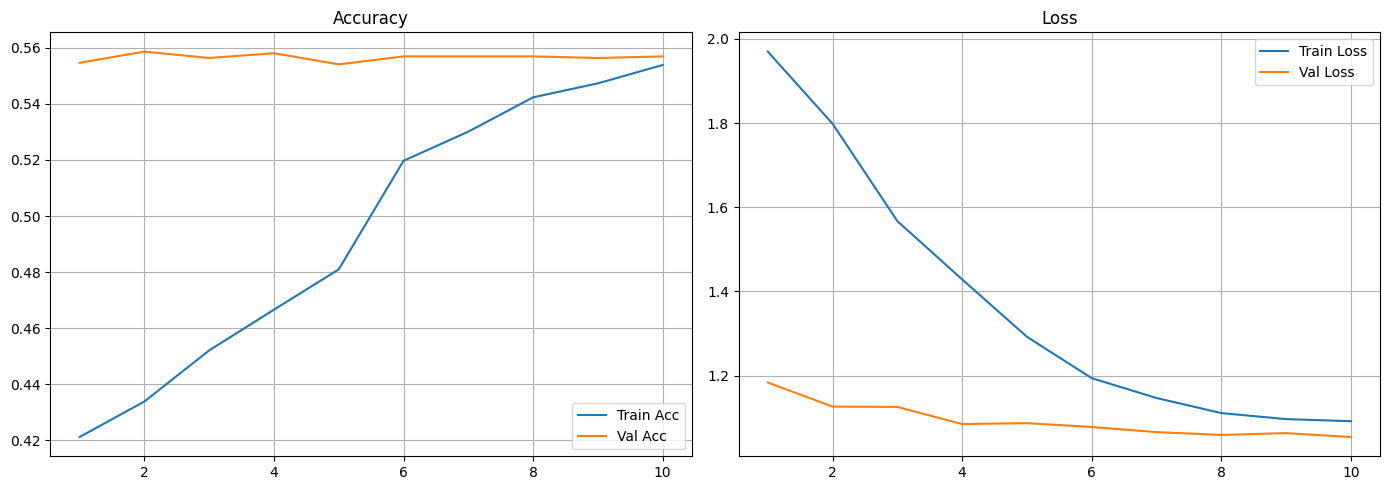

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

2025-04-10 18:37:20.312476: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


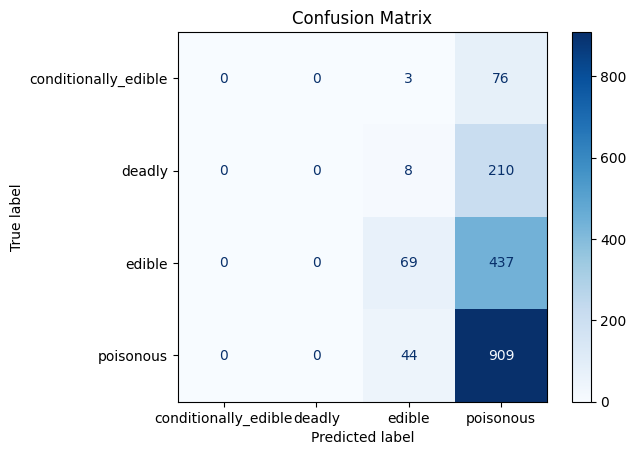

ft_last_0_flip_simple done | Val Acc: 0.5569 | Val Loss: 1.0542

Running: ft_last_30_flip_simple (fine-tuned)
Epoch 1/10


/Users/mikolajkahl/.pyenv/versions/tfmacos-310/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


110/110 ━━━━━━━━━━━━━━━━━━━━ 45s 349ms/step - accuracy: 0.3830 - loss: 1.6358 - val_accuracy: 0.5251 - val_loss: 1.2411
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 36s 325ms/step - accuracy: 0.4556 - loss: 1.3556 - val_accuracy: 0.5364 - val_loss: 1.2172
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 35s 319ms/step - accuracy: 0.4660 - loss: 1.2995 - val_accuracy: 0.5370 - val_loss: 1.1979
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 36s 326ms/step - accuracy: 0.4847 - loss: 1.2426 - val_accuracy: 0.5416 - val_loss: 1.1807
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 35s 321ms/step - accuracy: 0.5008 - loss: 1.2148 - val_accuracy: 0.5484 - val_loss: 1.1814
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 35s 322ms/step - accuracy: 0.5057 - loss: 1.1913 - val_accuracy: 0.5456 - val_loss: 1.1713
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 35s 315ms/step - accuracy: 0.5208 - loss: 1.1599 - val_accuracy: 0.5370 - val_loss: 1.1598
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 35s 319ms/step - accuracy: 0.5297 - loss: 1.1364 - val

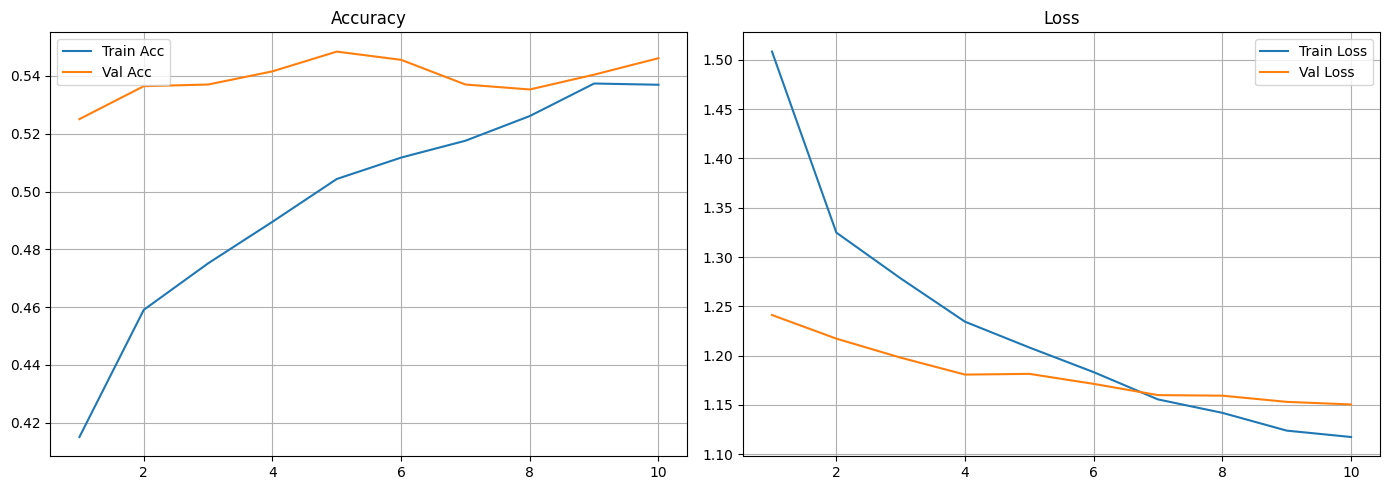

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

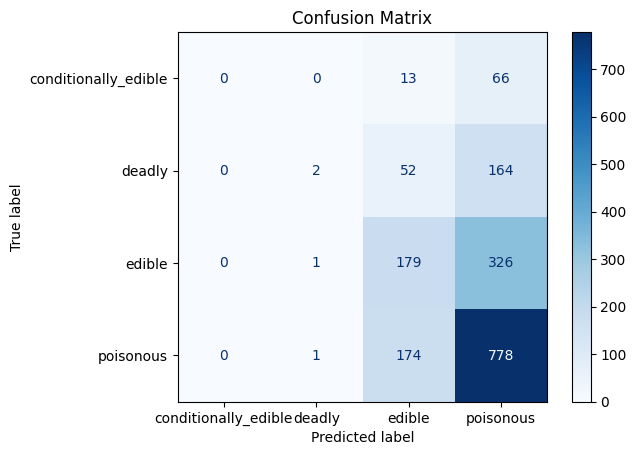

ft_last_30_flip_simple done | Val Acc: 0.5461 | Val Loss: 1.1504

Running: ft_last_50_flip_simple (fine-tuned)
Epoch 1/10


/Users/mikolajkahl/.pyenv/versions/tfmacos-310/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


110/110 ━━━━━━━━━━━━━━━━━━━━ 57s 440ms/step - accuracy: 0.3416 - loss: 1.5959 - val_accuracy: 0.3696 - val_loss: 1.4005
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 46s 414ms/step - accuracy: 0.4637 - loss: 1.3450 - val_accuracy: 0.4060 - val_loss: 1.3568
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 45s 408ms/step - accuracy: 0.4984 - loss: 1.2685 - val_accuracy: 0.4169 - val_loss: 1.3384
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 45s 409ms/step - accuracy: 0.5114 - loss: 1.2242 - val_accuracy: 0.4277 - val_loss: 1.3137
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 45s 406ms/step - accuracy: 0.5033 - loss: 1.2002 - val_accuracy: 0.4385 - val_loss: 1.2956
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 45s 407ms/step - accuracy: 0.5132 - loss: 1.1897 - val_accuracy: 0.4482 - val_loss: 1.2787
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 46s 411ms/step - accuracy: 0.5275 - loss: 1.1442 - val_accuracy: 0.4590 - val_loss: 1.2605
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 45s 413ms/step - accuracy: 0.5395 - loss: 1.1292 - val

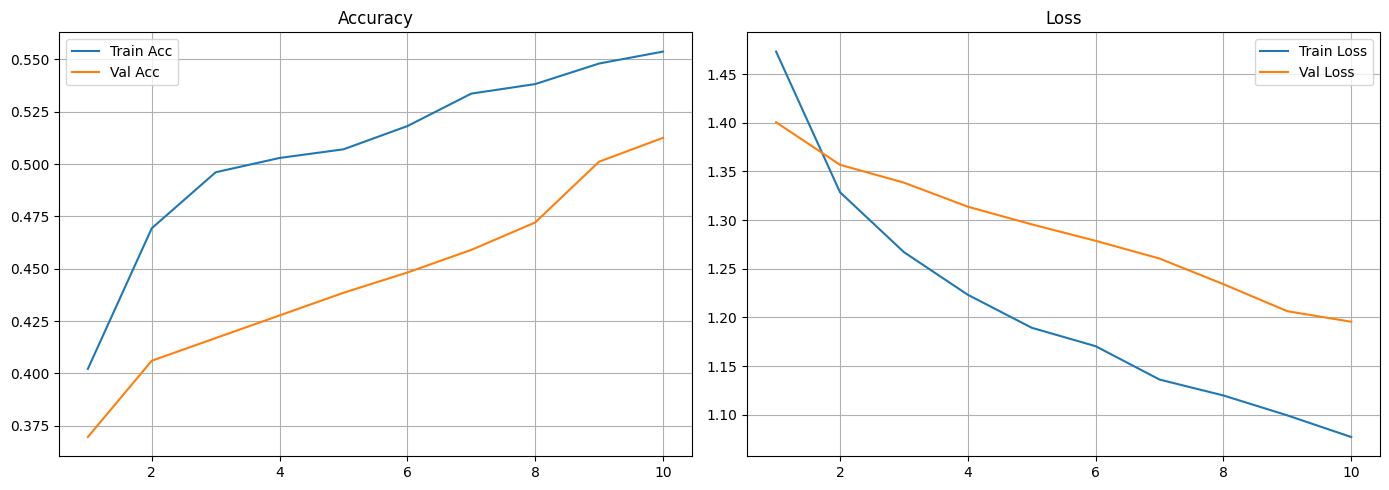

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

2025-04-10 18:51:28.322457: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


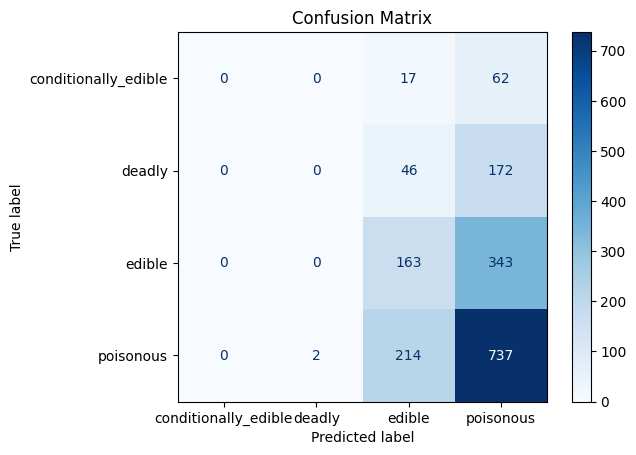

ft_last_50_flip_simple done | Val Acc: 0.5125 | Val Loss: 1.1955

Running: ft_last_80_flip_simple (fine-tuned)
Epoch 1/10


/Users/mikolajkahl/.pyenv/versions/tfmacos-310/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


110/110 ━━━━━━━━━━━━━━━━━━━━ 79s 593ms/step - accuracy: 0.4070 - loss: 1.5270 - val_accuracy: 0.2392 - val_loss: 1.7522
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 60s 543ms/step - accuracy: 0.4593 - loss: 1.3611 - val_accuracy: 0.2984 - val_loss: 1.5923
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 60s 543ms/step - accuracy: 0.4793 - loss: 1.2992 - val_accuracy: 0.3252 - val_loss: 1.4647
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 60s 542ms/step - accuracy: 0.4987 - loss: 1.2339 - val_accuracy: 0.3588 - val_loss: 1.3696
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 60s 546ms/step - accuracy: 0.5013 - loss: 1.2187 - val_accuracy: 0.4049 - val_loss: 1.2996
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 60s 550ms/step - accuracy: 0.5154 - loss: 1.1847 - val_accuracy: 0.4362 - val_loss: 1.2504
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 63s 572ms/step - accuracy: 0.5223 - loss: 1.1486 - val_accuracy: 0.4710 - val_loss: 1.2127
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 60s 549ms/step - accuracy: 0.5232 - loss: 1.1553 - val

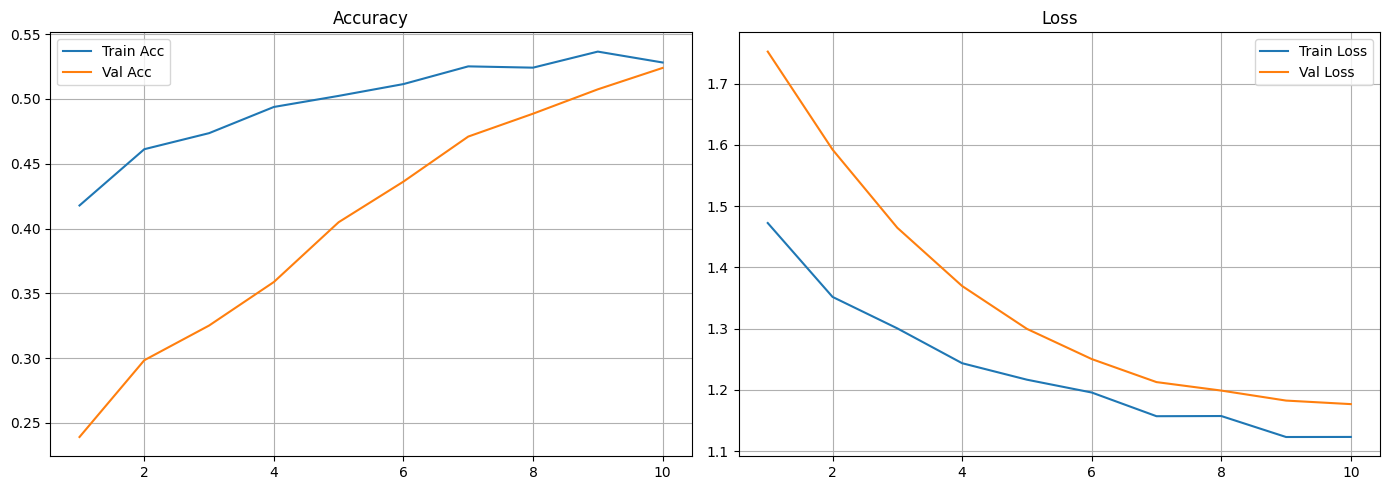

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

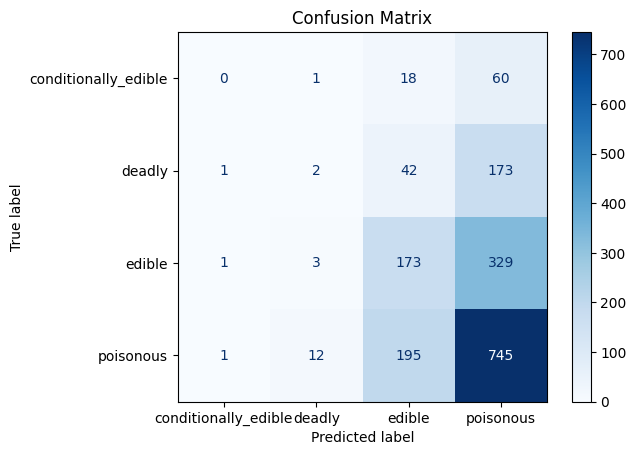

ft_last_80_flip_simple done | Val Acc: 0.5239 | Val Loss: 1.1768

Running: ft_all_layers_flip_simple (fine-tuned)
Epoch 1/10


/Users/mikolajkahl/.pyenv/versions/tfmacos-310/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


110/110 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.3306 - loss: 1.7022 - val_accuracy: 0.4391 - val_loss: 1.3408
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.4939 - loss: 1.2809 - val_accuracy: 0.5097 - val_loss: 1.2295
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.5146 - loss: 1.2096 - val_accuracy: 0.5427 - val_loss: 1.1866
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.5462 - loss: 1.1257 - val_accuracy: 0.5513 - val_loss: 1.1542
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.5566 - loss: 1.1009 - val_accuracy: 0.5661 - val_loss: 1.1284
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.5748 - loss: 1.0548 - val_accuracy: 0.5786 - val_loss: 1.1006
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.5869 - loss: 1.0052 - val_accuracy: 0.5905 - val_loss: 1.0724
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.6104 - loss: 0.9629 - val_accuracy: 0.600

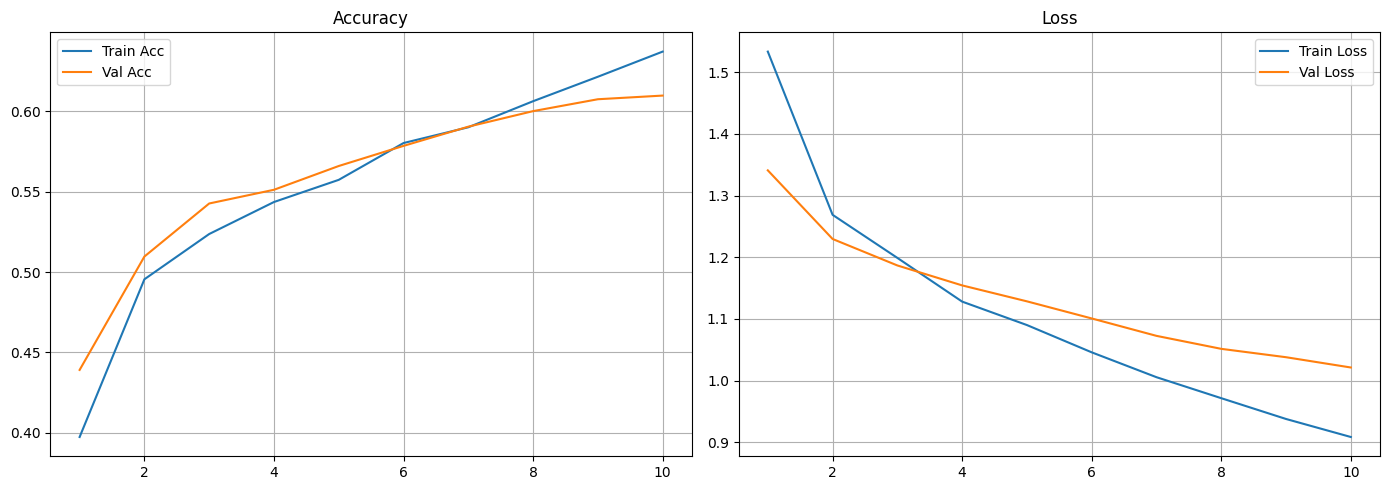

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

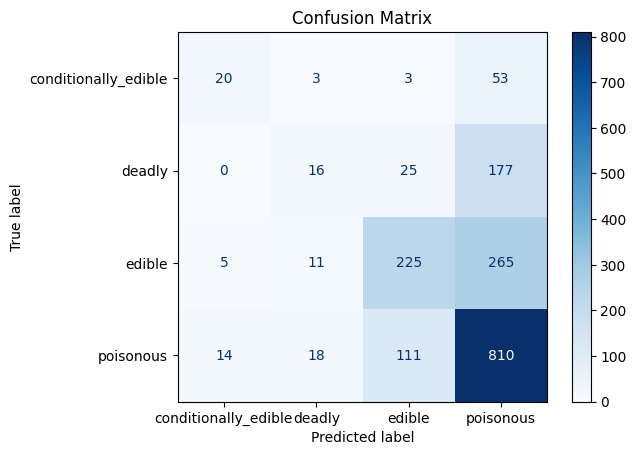

ft_all_layers_flip_simple done | Val Acc: 0.6099 | Val Loss: 1.0211

Running: ft_last_30_flip_zoom_simple (fine-tuned)
Epoch 1/10


/Users/mikolajkahl/.pyenv/versions/tfmacos-310/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


110/110 ━━━━━━━━━━━━━━━━━━━━ 58s 408ms/step - accuracy: 0.4199 - loss: 1.4279 - val_accuracy: 0.5028 - val_loss: 1.4061
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 38s 346ms/step - accuracy: 0.4621 - loss: 1.3298 - val_accuracy: 0.5205 - val_loss: 1.3314
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 38s 344ms/step - accuracy: 0.4856 - loss: 1.2704 - val_accuracy: 0.5273 - val_loss: 1.2865
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 38s 346ms/step - accuracy: 0.4956 - loss: 1.2299 - val_accuracy: 0.5364 - val_loss: 1.2526
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 39s 355ms/step - accuracy: 0.4925 - loss: 1.2074 - val_accuracy: 0.5382 - val_loss: 1.2343
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 42s 381ms/step - accuracy: 0.5065 - loss: 1.1919 - val_accuracy: 0.5404 - val_loss: 1.2135
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 44s 397ms/step - accuracy: 0.5056 - loss: 1.1948 - val_accuracy: 0.5421 - val_loss: 1.2072
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 38s 342ms/step - accuracy: 0.4984 - loss: 1.1966 - val

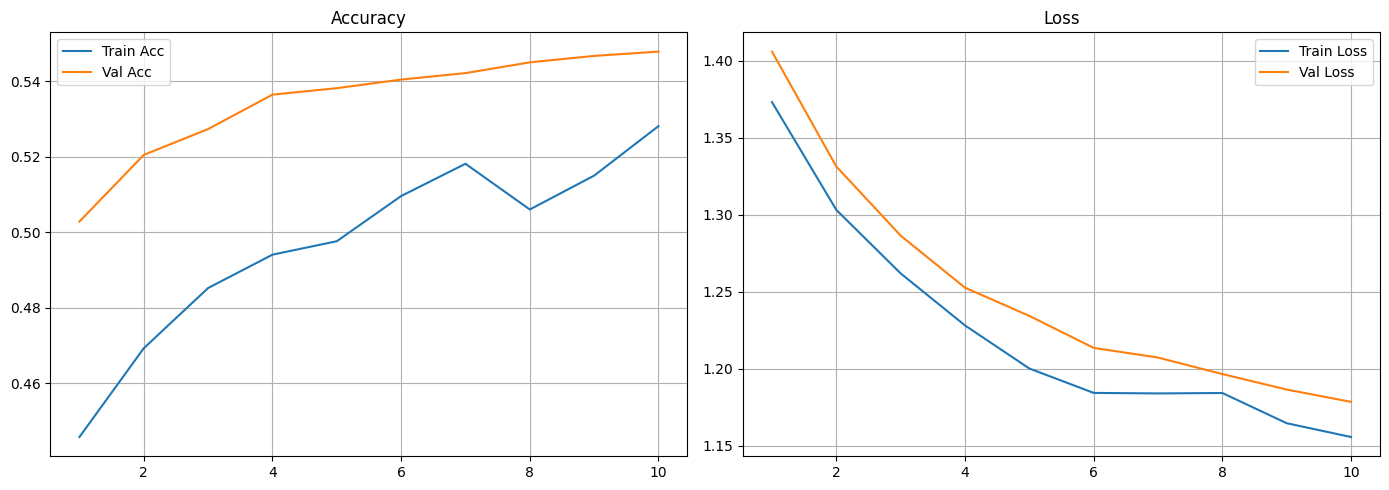

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

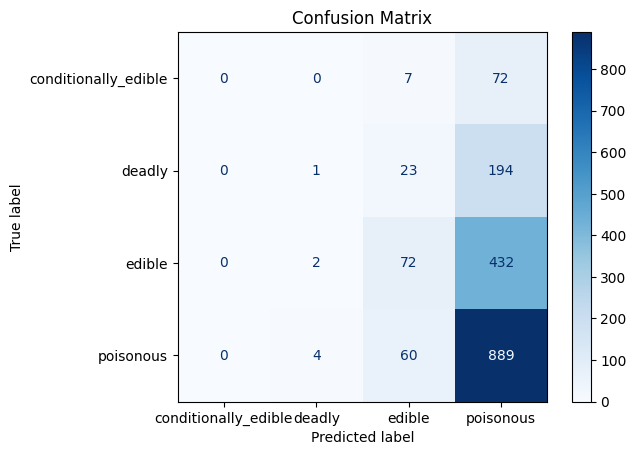

ft_last_30_flip_zoom_simple done | Val Acc: 0.5478 | Val Loss: 1.1784

Running: ft_last_30_flip_rotate_simple (fine-tuned)
Epoch 1/10


/Users/mikolajkahl/.pyenv/versions/tfmacos-310/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


110/110 ━━━━━━━━━━━━━━━━━━━━ 58s 418ms/step - accuracy: 0.3965 - loss: 1.4566 - val_accuracy: 0.4379 - val_loss: 1.4624
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 39s 350ms/step - accuracy: 0.4718 - loss: 1.3058 - val_accuracy: 0.4818 - val_loss: 1.3845
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 39s 356ms/step - accuracy: 0.4612 - loss: 1.3061 - val_accuracy: 0.5028 - val_loss: 1.3473
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 39s 352ms/step - accuracy: 0.4759 - loss: 1.2625 - val_accuracy: 0.5211 - val_loss: 1.2909
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 39s 355ms/step - accuracy: 0.5037 - loss: 1.2277 - val_accuracy: 0.5387 - val_loss: 1.2715
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 40s 364ms/step - accuracy: 0.4931 - loss: 1.2216 - val_accuracy: 0.5404 - val_loss: 1.2411
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 41s 373ms/step - accuracy: 0.4905 - loss: 1.2329 - val_accuracy: 0.5421 - val_loss: 1.2204
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 40s 362ms/step - accuracy: 0.4938 - loss: 1.2126 - val

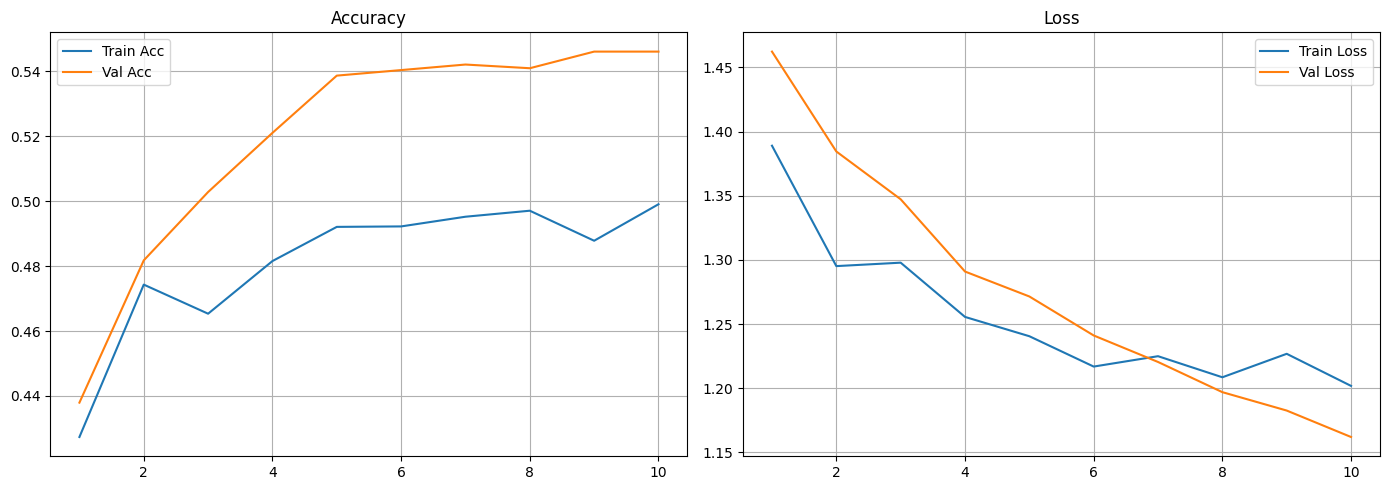

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

2025-04-10 19:41:34.527356: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


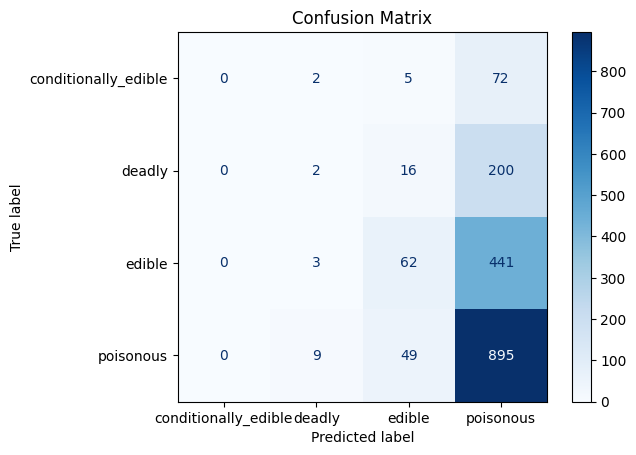

ft_last_30_flip_rotate_simple done | Val Acc: 0.5461 | Val Loss: 1.1619

Running: ft_last_30_flip_deep (fine-tuned)
Epoch 1/10


/Users/mikolajkahl/.pyenv/versions/tfmacos-310/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


110/110 ━━━━━━━━━━━━━━━━━━━━ 54s 399ms/step - accuracy: 0.3562 - loss: 1.9150 - val_accuracy: 0.4823 - val_loss: 1.3387
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 38s 350ms/step - accuracy: 0.4343 - loss: 1.6964 - val_accuracy: 0.4681 - val_loss: 1.3022
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 36s 331ms/step - accuracy: 0.4481 - loss: 1.6174 - val_accuracy: 0.4636 - val_loss: 1.2885
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 36s 331ms/step - accuracy: 0.4502 - loss: 1.5840 - val_accuracy: 0.4692 - val_loss: 1.2862
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 36s 331ms/step - accuracy: 0.4725 - loss: 1.5615 - val_accuracy: 0.4784 - val_loss: 1.2738
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 36s 331ms/step - accuracy: 0.4604 - loss: 1.5628 - val_accuracy: 0.4932 - val_loss: 1.2620
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 36s 328ms/step - accuracy: 0.4751 - loss: 1.5199 - val_accuracy: 0.4909 - val_loss: 1.2584
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 36s 329ms/step - accuracy: 0.4701 - loss: 1.5137 - val

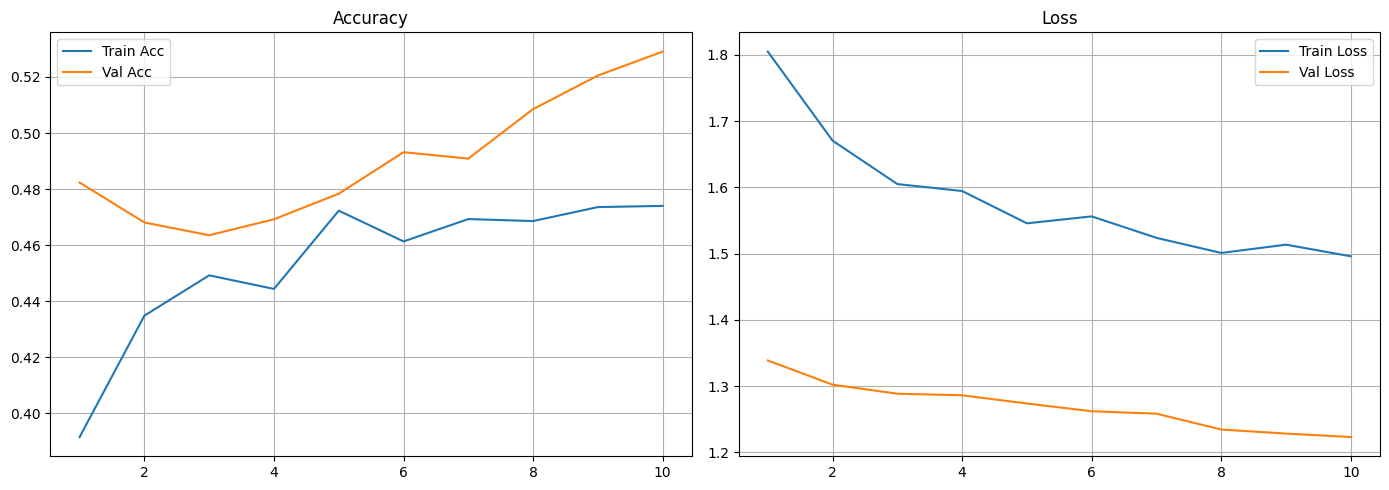

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

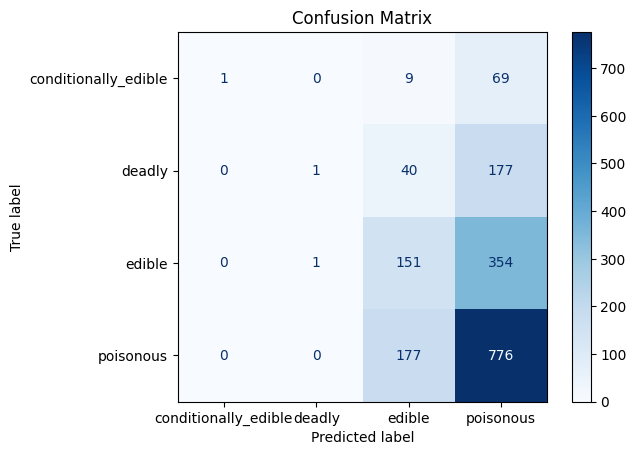

ft_last_30_flip_deep done | Val Acc: 0.5290 | Val Loss: 1.2232

Running: ft_last_30_flip_minimal (fine-tuned)
Epoch 1/10


/Users/mikolajkahl/.pyenv/versions/tfmacos-310/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


110/110 ━━━━━━━━━━━━━━━━━━━━ 59s 411ms/step - accuracy: 0.3109 - loss: 1.4656 - val_accuracy: 0.0757 - val_loss: 3.4153
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 36s 329ms/step - accuracy: 0.5369 - loss: 1.1198 - val_accuracy: 0.0644 - val_loss: 3.2501
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 37s 334ms/step - accuracy: 0.5625 - loss: 1.0610 - val_accuracy: 0.0826 - val_loss: 2.7870
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 37s 335ms/step - accuracy: 0.5764 - loss: 1.0312 - val_accuracy: 0.1093 - val_loss: 2.3819
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 36s 328ms/step - accuracy: 0.5816 - loss: 1.0022 - val_accuracy: 0.1503 - val_loss: 2.0585
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 66s 602ms/step - accuracy: 0.5979 - loss: 0.9740 - val_accuracy: 0.1953 - val_loss: 1.8242
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.6085 - loss: 0.9455 - val_accuracy: 0.2403 - val_loss: 1.6343
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 36s 331ms/step - accuracy: 0.6176 - loss: 0.9191 - val_a

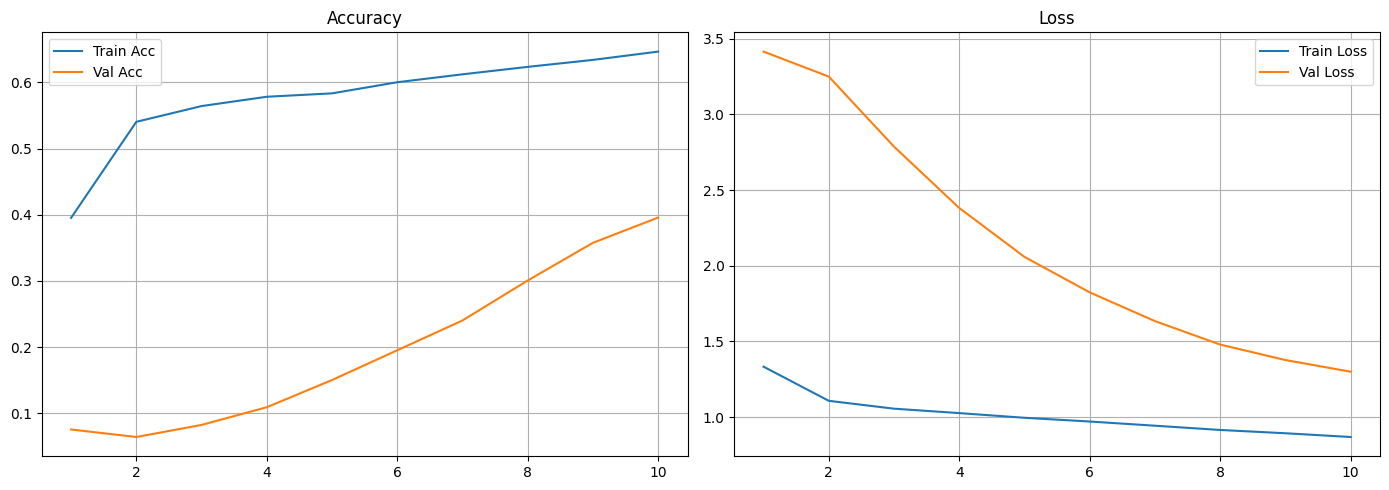

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

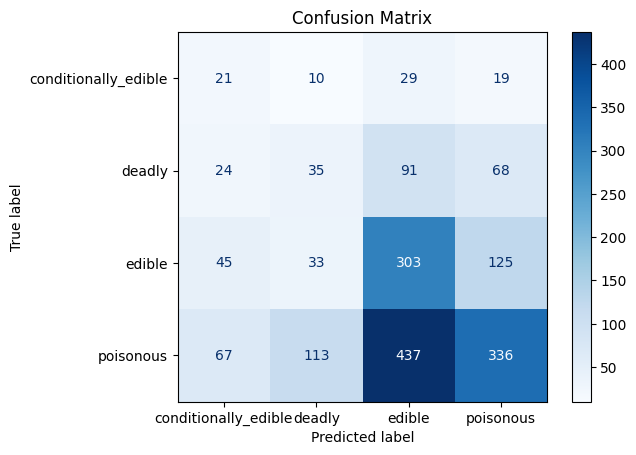

ft_last_30_flip_minimal done | Val Acc: 0.3958 | Val Loss: 1.2999

Running: ft_last_30_flip_simple_lr_1e-4 (fine-tuned)
Epoch 1/10


/Users/mikolajkahl/.pyenv/versions/tfmacos-310/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


110/110 ━━━━━━━━━━━━━━━━━━━━ 56s 401ms/step - accuracy: 0.4325 - loss: 1.4572 - val_accuracy: 0.5330 - val_loss: 1.3202
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 36s 328ms/step - accuracy: 0.5396 - loss: 1.1323 - val_accuracy: 0.5410 - val_loss: 1.4093
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 37s 331ms/step - accuracy: 0.5781 - loss: 1.0275 - val_accuracy: 0.5438 - val_loss: 1.5583
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 36s 332ms/step - accuracy: 0.5912 - loss: 0.9862 - val_accuracy: 0.5433 - val_loss: 1.3298
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 37s 335ms/step - accuracy: 0.6450 - loss: 0.8827 - val_accuracy: 0.5296 - val_loss: 1.2587
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 37s 334ms/step - accuracy: 0.6799 - loss: 0.7858 - val_accuracy: 0.3929 - val_loss: 1.3980
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 37s 335ms/step - accuracy: 0.7368 - loss: 0.6730 - val_accuracy: 0.4721 - val_loss: 1.2828
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 36s 329ms/step - accuracy: 0.7711 - loss: 0.5901 - val

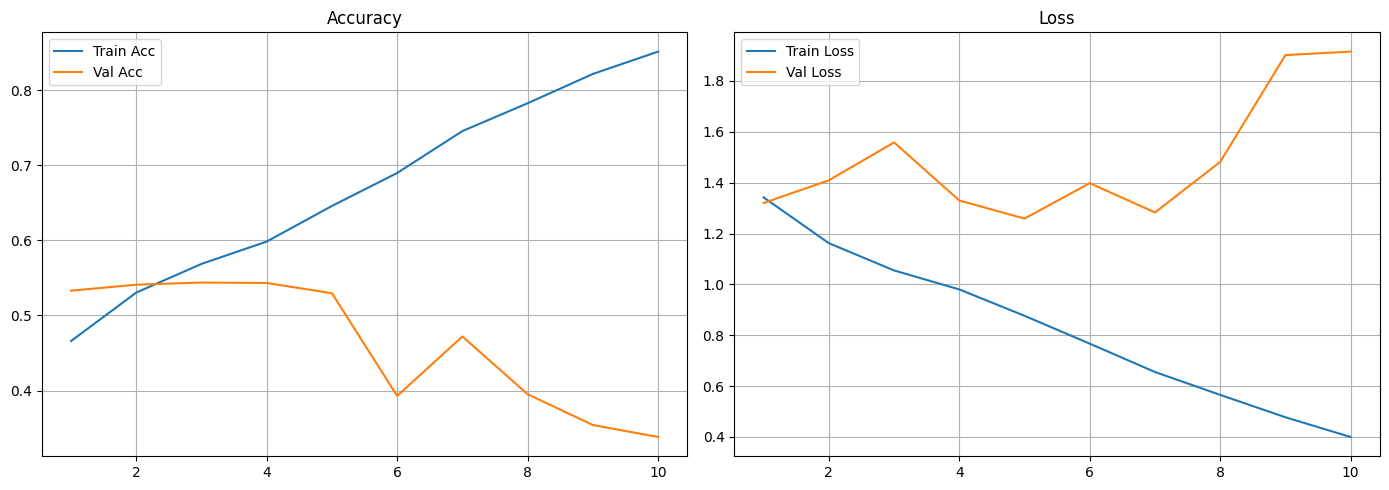

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

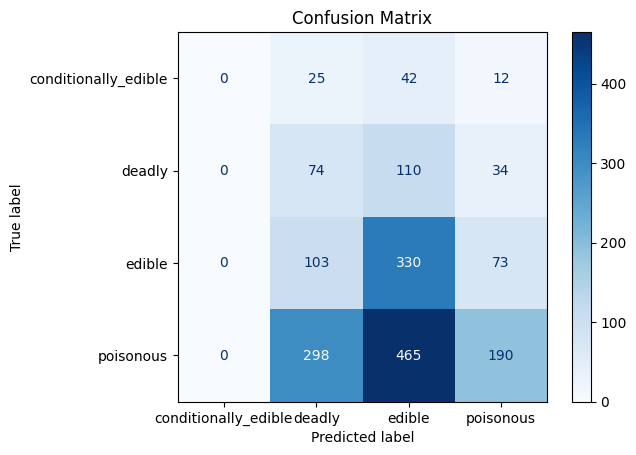

ft_last_30_flip_simple_lr_1e-4 done | Val Acc: 0.3383 | Val Loss: 1.9153

Running: ft_last_30_flip_simple_lr_1e-6 (fine-tuned)
Epoch 1/10


/Users/mikolajkahl/.pyenv/versions/tfmacos-310/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


110/110 ━━━━━━━━━━━━━━━━━━━━ 62s 436ms/step - accuracy: 0.2755 - loss: 1.6745 - val_accuracy: 0.3576 - val_loss: 1.5455
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 36s 329ms/step - accuracy: 0.3320 - loss: 1.5430 - val_accuracy: 0.3793 - val_loss: 1.5149
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 37s 330ms/step - accuracy: 0.3848 - loss: 1.4612 - val_accuracy: 0.4066 - val_loss: 1.4736
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 36s 325ms/step - accuracy: 0.4035 - loss: 1.4043 - val_accuracy: 0.4231 - val_loss: 1.4356
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 36s 326ms/step - accuracy: 0.4399 - loss: 1.3863 - val_accuracy: 0.4391 - val_loss: 1.4039
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 36s 325ms/step - accuracy: 0.4503 - loss: 1.3566 - val_accuracy: 0.4539 - val_loss: 1.3740
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 36s 324ms/step - accuracy: 0.4417 - loss: 1.3525 - val_accuracy: 0.4704 - val_loss: 1.3464
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 37s 334ms/step - accuracy: 0.4442 - loss: 1.3395 - val

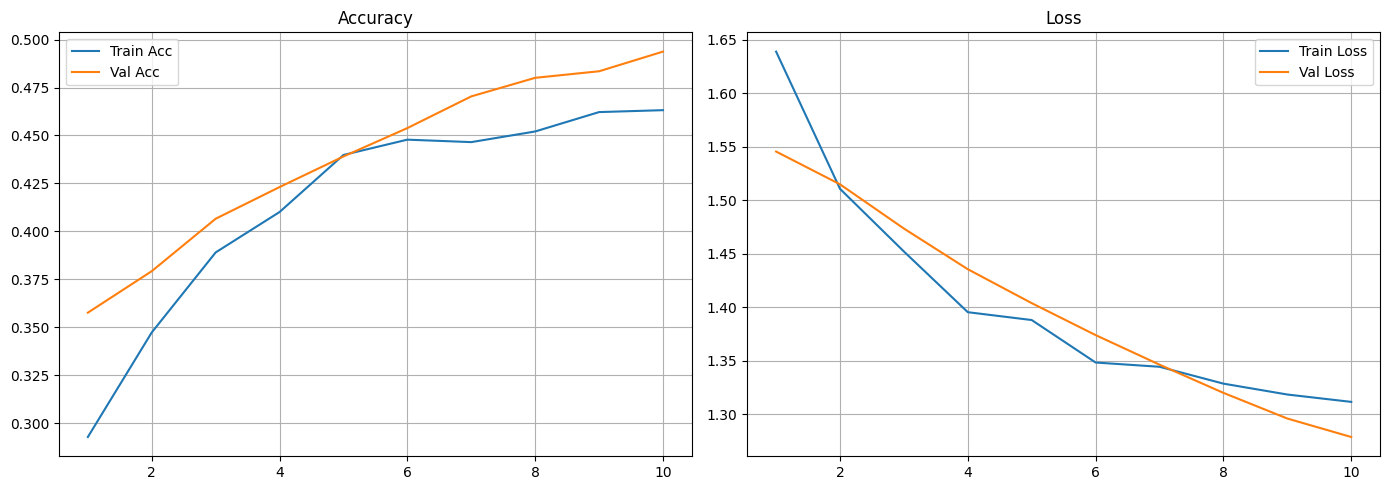

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

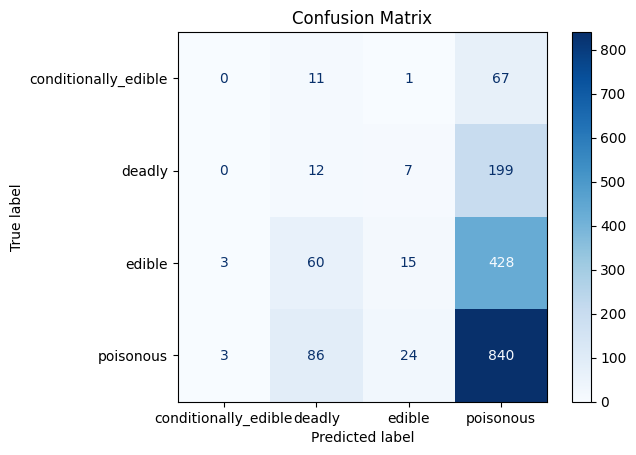

ft_last_30_flip_simple_lr_1e-6 done | Val Acc: 0.4937 | Val Loss: 1.2788

Running: ft_last_30_flip_simple_5_epochs (fine-tuned)
Epoch 1/5


/Users/mikolajkahl/.pyenv/versions/tfmacos-310/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


110/110 ━━━━━━━━━━━━━━━━━━━━ 388s 3s/step - accuracy: 0.3963 - loss: 1.4923 - val_accuracy: 0.4243 - val_loss: 1.2493
Epoch 2/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 36s 324ms/step - accuracy: 0.4699 - loss: 1.2942 - val_accuracy: 0.4402 - val_loss: 1.2239
Epoch 3/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 65s 594ms/step - accuracy: 0.4900 - loss: 1.2495 - val_accuracy: 0.4544 - val_loss: 1.2041
Epoch 4/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 705s 6s/step - accuracy: 0.4945 - loss: 1.2089 - val_accuracy: 0.4664 - val_loss: 1.1920
Epoch 5/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 35s 319ms/step - accuracy: 0.5147 - loss: 1.1742 - val_accuracy: 0.4692 - val_loss: 1.1895


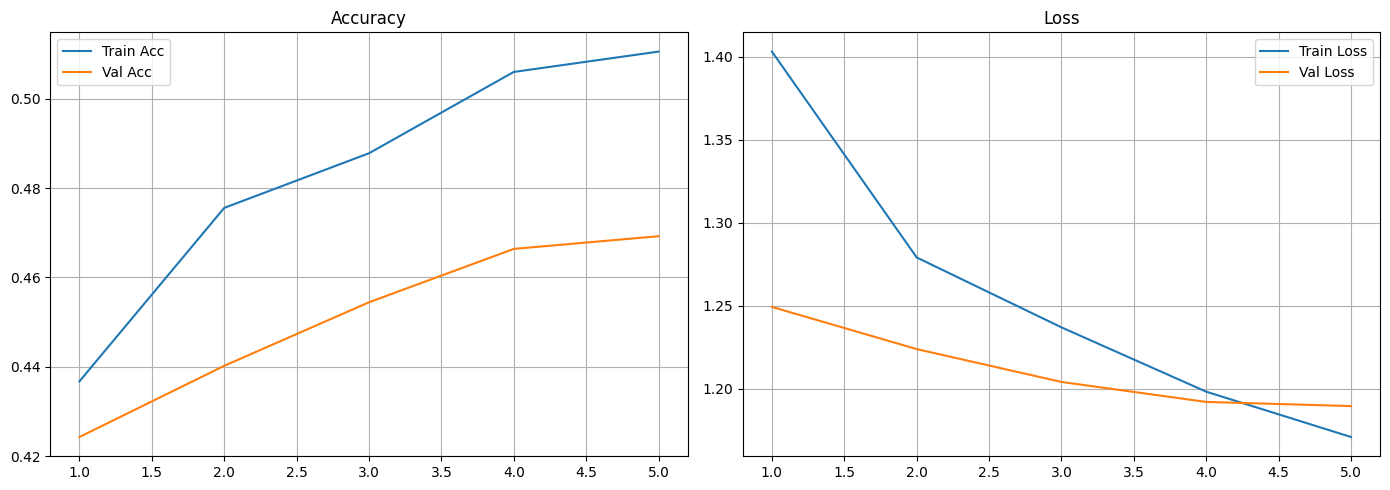

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

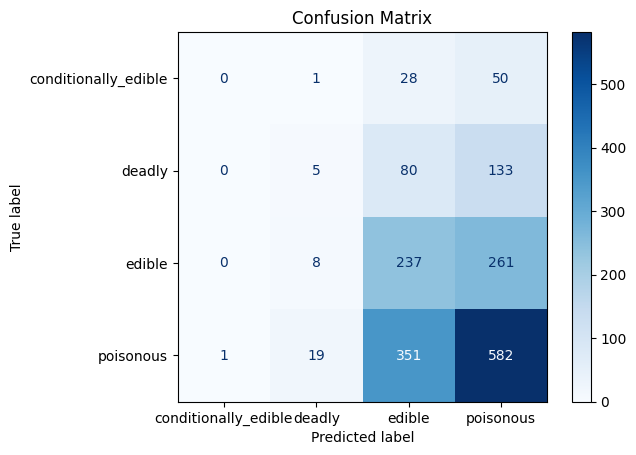

ft_last_30_flip_simple_5_epochs done | Val Acc: 0.4692 | Val Loss: 1.1895

Running: ft_last_30_flip_simple_15_epochs (fine-tuned)
Epoch 1/15


/Users/mikolajkahl/.pyenv/versions/tfmacos-310/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


110/110 ━━━━━━━━━━━━━━━━━━━━ 431s 4s/step - accuracy: 0.3713 - loss: 1.5916 - val_accuracy: 0.5353 - val_loss: 1.2829
Epoch 2/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 945s 9s/step - accuracy: 0.4745 - loss: 1.2972 - val_accuracy: 0.5251 - val_loss: 1.2587
Epoch 3/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 589s 5s/step - accuracy: 0.4889 - loss: 1.2614 - val_accuracy: 0.5114 - val_loss: 1.2502
Epoch 4/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 36s 326ms/step - accuracy: 0.4990 - loss: 1.2340 - val_accuracy: 0.5091 - val_loss: 1.2404
Epoch 5/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 70s 637ms/step - accuracy: 0.5114 - loss: 1.1903 - val_accuracy: 0.4989 - val_loss: 1.2299
Epoch 6/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.5080 - loss: 1.1874 - val_accuracy: 0.4994 - val_loss: 1.2175
Epoch 7/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 36s 325ms/step - accuracy: 0.5290 - loss: 1.1471 - val_accuracy: 0.5034 - val_loss: 1.2038
Epoch 8/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 102s 929ms/step - accuracy: 0.5395 - loss: 1.1106 - val_accura

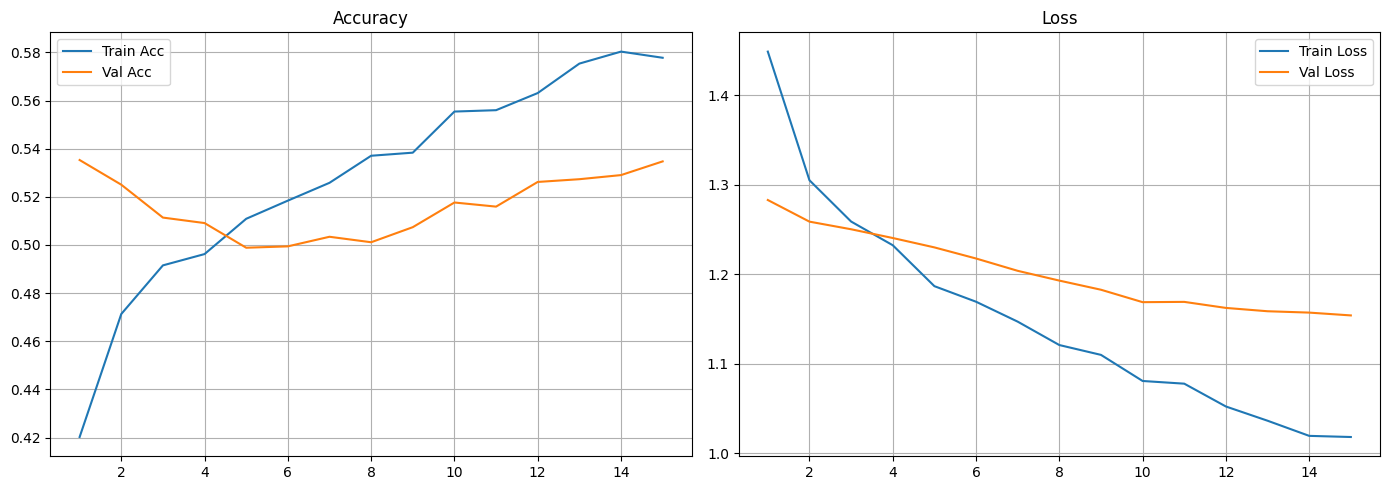

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 388ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 492ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

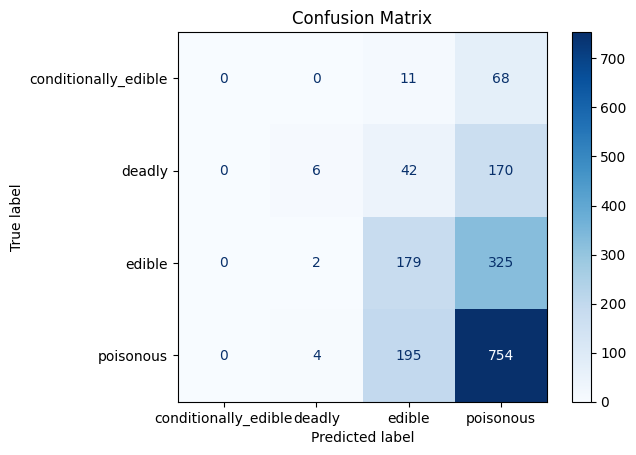

ft_last_30_flip_simple_15_epochs done | Val Acc: 0.5347 | Val Loss: 1.1540


In [18]:
results = []

for exp in experiments:
    result = run_experiment(
        name=exp["name"],
        fine_tune=exp["fine_tune"],
        fine_tune_at=exp.get("fine_tune_at", -30),  # use default if None
        learning_rate=exp["learning_rate"],
        epochs=exp["epochs"],
        augmentation_name=exp["augmentation_name"],
        classifier_name=exp["classifier_name"]
    )
    results.append(result)


In [19]:
df_results = pd.DataFrame(results)[[
    "name", "fine_tune", "fine_tune_at", "learning_rate",
    "epochs", "augmentation", "classifier", "val_accuracy", "val_loss"
]]
df_results = df_results.sort_values("val_accuracy", ascending=False)
df_results


,name,fine_tune,fine_tune_at,learning_rate,epochs,augmentation,classifier,val_accuracy,val_loss
4,ft_all_layers_flip_simple,True,0.0,0.000010,10,flip,simple,0.609909,1.021106
0,ft_last_0_flip_simple,False,NaN,0.001000,10,flip,simple,0.556948,1.054246
5,ft_last_30_flip_zoom_simple,True,-30.0,0.000010,10,flip_zoom,simple,0.547836,1.178436
1,ft_last_30_flip_simple,True,-30.0,0.000010,10,flip,simple,0.546128,1.150364
6,ft_last_30_flip_rotate_simple,True,-30.0,0.000010,10,flip_rotate,simple,0.546128,1.161935
12,ft_last_30_flip_simple_15_epochs,True,-30.0,0.000010,15,flip,simple,0.534738,1.153973
7,ft_last_30_flip_deep,True,-30.0,0.000010,10,flip,deep,0.529043,1.223170
3,ft_last_80_flip_simple,True,-80.0,0.000010,10,flip,simple,0.523918,1.176780
2,ft_last_50_flip_simple,True,-50.0,0.000010,10,flip,simple,0.512528,1.195525
10,ft_last_30_flip_simple_lr_1e-6,True,-30.0,0.000001,10,flip,simple,0.493736,1.278810
